Skipped 21717 things because of zero cycles
Skipped 1943 things because of too many removed cycles
Skipped 0 things because of too many missing cycle seconds
Skipped 0 things because of too many missing primary signals
Skipped 2576 things because of too many skipped cycles


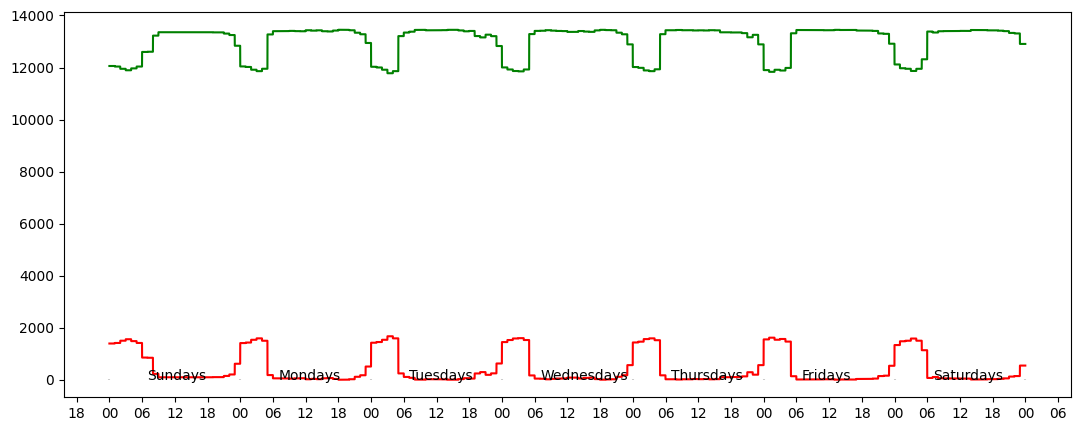

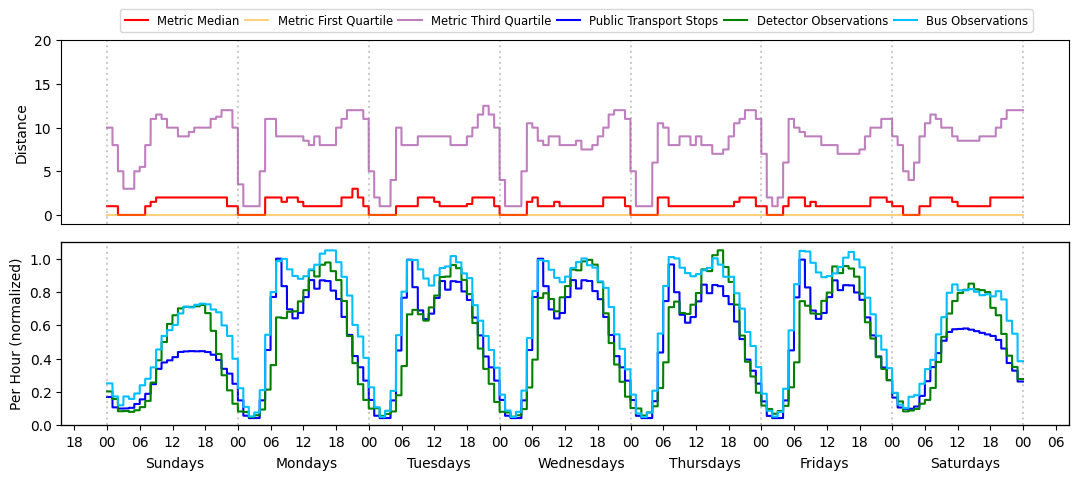

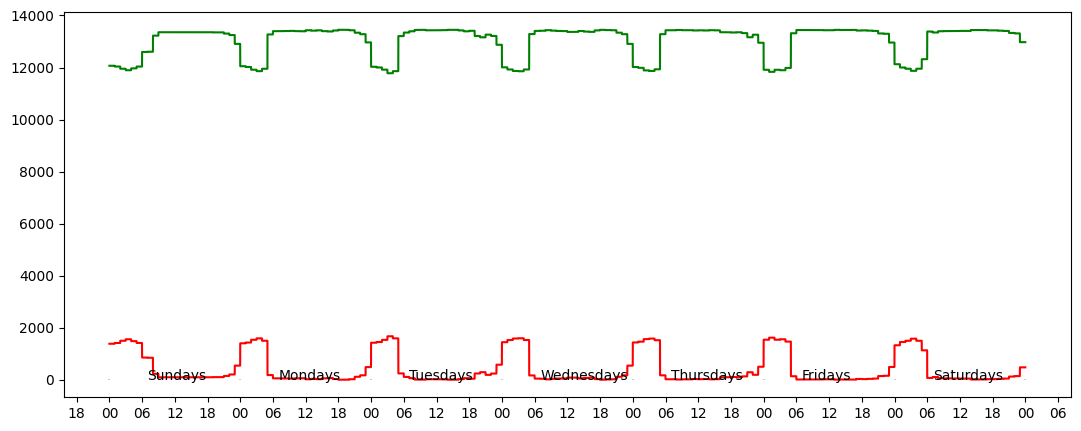

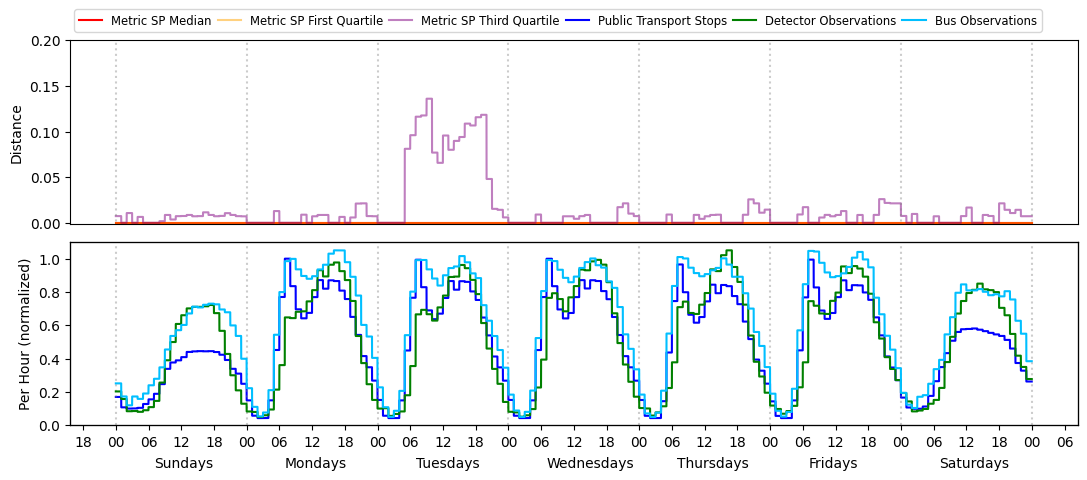

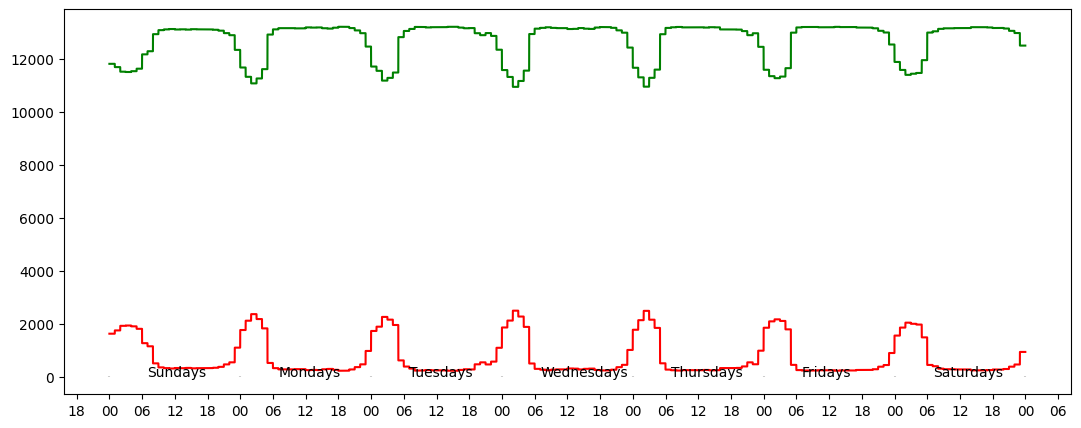

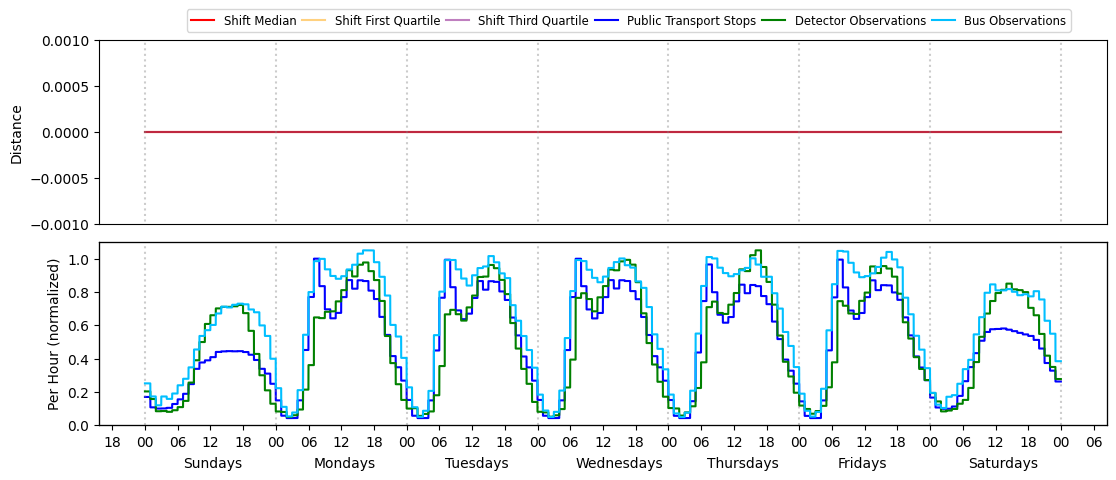

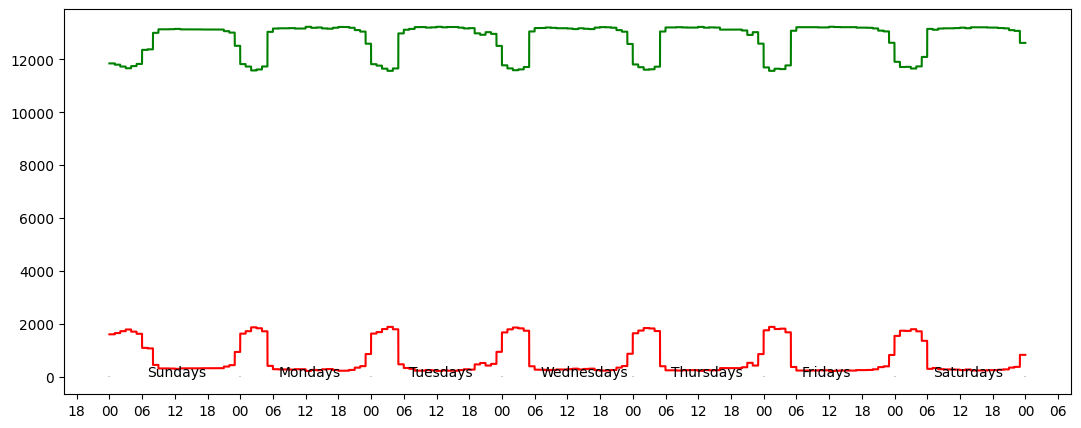

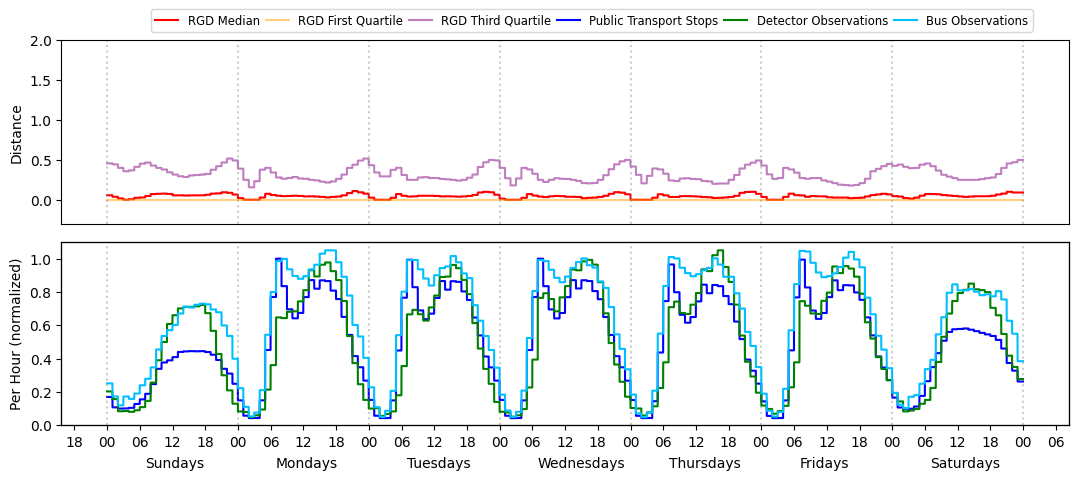

In [13]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import datetime
from os import listdir
from os.path import isfile, join
import collections
import matplotlib.gridspec as gridspec

def convert_cells_to_local_time(cells):
    local_cells = [
        [
            [] for i in range(24)
        ] for j in range(7)
    ]
    
    for day_idx in range(7):
        for hour_idx in range(24):
            new_hour_idx = hour_idx + 2 # (summer time)
            new_day_idx = day_idx
            if new_hour_idx >= 24:
                new_day_idx = (day_idx + 1) % 7
                new_hour_idx = new_hour_idx % 24
            
            local_cells[new_day_idx][new_hour_idx] = cells[day_idx][hour_idx]
    
    return cells

def get_observation_per_hour_cells(observations_per_hour_counts):
    observations_per_hour_timestamp_counts_ordered = collections.OrderedDict(sorted(observations_per_hour_counts.items(), reverse=True))

    observations_per_hour_timestamp_counts_aggregated = [
        [
            [] for j in range(24)    
        ] for i in range(7)
    ]

    day_idx = 4
    hour_idx = 23
    day_count = 0

    factor = 7*24*3600
        
    for timestamp, count in observations_per_hour_timestamp_counts_ordered.items():
        # End time (took von times.go code)
        """ location, err := time.LoadLocation("Europe/Berlin")
        if err != nil {
            panic(err)
        }
        endDate := time.Date(2023, 10, 20, 0, 0, 0, 0, location) """
        int_timestamp = int(timestamp.replace(".0", ""))
        if int_timestamp >= 1697752800:
            continue
        
        last_count = count
        third_count = observations_per_hour_timestamp_counts_ordered[str(int_timestamp - (1 * factor)) + ".0"]
        second_count = observations_per_hour_timestamp_counts_ordered[str(int_timestamp - (2 * factor)) + ".0"]
        first_count = observations_per_hour_timestamp_counts_ordered[str(int_timestamp - (3 * factor)) + ".0"]
        
        observations_per_hour_timestamp_counts_aggregated[day_idx][hour_idx] = [first_count, second_count, third_count, last_count]
        
        first_datetime = datetime.datetime.fromtimestamp(int_timestamp - (3 * factor))
        second_datetime = datetime.datetime.fromtimestamp(int_timestamp - (2 * factor))
        third_datetime = datetime.datetime.fromtimestamp(int_timestamp - (1 * factor))
        last_datetime = datetime.datetime.fromtimestamp(int_timestamp)
        
        if first_datetime.weekday() != second_datetime.weekday() or first_datetime.weekday() != third_datetime.weekday() or first_datetime.weekday() != last_datetime.weekday():
            raise Exception("Days do not match")
        if first_datetime.hour != second_datetime.hour or first_datetime.hour != third_datetime.hour or first_datetime.hour != last_datetime.hour:
            raise Exception("Hours do not match")
        if first_datetime.minute != 0 or second_datetime.minute != 0 or third_datetime.minute != 0 or last_datetime.minute != 0:
            raise Exception("Minutes do not match")
        if first_datetime.second != 0 or second_datetime.second != 0 or third_datetime.second != 0 or last_datetime.second != 0:
            raise Exception("Seconds do not match")
        
        if first_datetime.hour != hour_idx:
            raise Exception("Hours do not match")
        if first_datetime.weekday() != (day_idx - 1) % 7:
            raise Exception("Days do not match")
        
        hour_idx -= 1
        
        if hour_idx < 0:
            hour_idx = 23
            day_idx -= 1 % 7
            day_count += 1
        
        if day_count > 6:
            break
 
    return observations_per_hour_timestamp_counts_aggregated

public_transport_stoptimes = [[] for i in range(7)]
public_transport_stoptimes_files = [
    "sunday.json",
    "monday.json",
    "tuesday.json",
    "wednesday.json",
    "thursday.json",
    "friday.json",
    "saturday.json",
]

day_names = [
    "Sunday",
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday",
]

for i in range(7):
    with open(f"public_transport_stop_times/{public_transport_stoptimes_files[i]}") as f:
        public_transport_stoptimes[i] = json.load(f)
            
public_transport_stoptimes_hours = [[] for i in range(len(public_transport_stoptimes))]
for i in range(len(public_transport_stoptimes)):
    for stoptime in public_transport_stoptimes[i]:
        public_transport_stoptimes_hours[i].append(int(stoptime.split(":")[0]))
        
public_transport_stoptimes_hours_aggregated = [[0 for i in range(24)] for j in range(7)]
for i in range(len(public_transport_stoptimes_hours)):
    for hour in public_transport_stoptimes_hours[i]:
        public_transport_stoptimes_hours_aggregated[i][hour] += 1
        
public_transport_week_stop_times = []
for i in range(len(public_transport_stoptimes_hours_aggregated)):
    public_transport_week_stop_times += public_transport_stoptimes_hours_aggregated[i]
public_transport_week_stop_times_normalized = []
public_transport_stoptimes_max = np.max(np.array(public_transport_week_stop_times))
for stop_time in public_transport_week_stop_times:
    public_transport_week_stop_times_normalized += [stop_time / public_transport_stoptimes_max]
    
public_transport_week_stop_times_normalized = [val for val in public_transport_week_stop_times_normalized for _ in (0, 1)]
    
observations_per_hour_json_files = [f for f in listdir("observations_per_hour") if isfile(join("observations_per_hour", f))]
observations_per_hour_cells_by_datastream = {}
bus_count = 0
detector_count = 0
for observations_per_hour_json_file in observations_per_hour_json_files:
    if "signal" in observations_per_hour_json_file:
        continue
    with open(f"observations_per_hour/{observations_per_hour_json_file}") as f:
        name = observations_per_hour_json_file.replace("observations_per_hour_timestamp_counts_", "").replace(".json", "")
        if "bus" in name:
            name = "Bus Observations"
            bus_count += 1
        elif "detector" in name:
            name = "Detector Observations"
            detector_count += 1
        else:
            raise Exception("Unknown datastream")
        cells = get_observation_per_hour_cells(json.load(f))
        local_cells = convert_cells_to_local_time(cells)
        if name not in observations_per_hour_cells_by_datastream:
            observations_per_hour_cells_by_datastream[name] = local_cells
        else:
            for day_idx in range(7):
                for hour_idx in range(24):
                    observations_per_hour_cells_by_datastream[name][day_idx][hour_idx] += local_cells[day_idx][hour_idx]
                    
observations_per_hour_cells_by_datastream_medians = {}
                    
for name, cells in observations_per_hour_cells_by_datastream.items():
    observations_per_hour_cells_by_datastream_medians[name] = [
        [
            -1 for j in range(24)    
        ] for i in range(7)
    ]

    for dayIdx in range(7):
        for hourIdx in range(24):
            observations = cells[dayIdx][hourIdx]
            median = np.median(np.array(observations))
            observations_per_hour_cells_by_datastream_medians[name][dayIdx][hourIdx] = median
        
observations_per_hour_week_by_datastream = {}
for name, cells in observations_per_hour_cells_by_datastream_medians.items():
    observations = []
    for day_idx in range(7):
        for hour_idx in range(24):
            observations.append(cells[day_idx][hour_idx])
    observations_per_hour_week_by_datastream[name] = observations
observations_per_hour_week_by_datastream_normalized = {}
for name, observations in observations_per_hour_week_by_datastream.items():
    observations_per_hour_week_by_datastream_normalized[name] = []
    max_value = np.max(np.array(observations))
    for observation in observations:
        observations_per_hour_week_by_datastream_normalized[name].append(observation / max_value)

with open('processed_things_2023_11_15.json') as f:
    processed_things = json.load(f)
    
metrics = [
    {
        "name": "Metric",
        "key": "Metrics",
        "ylim": [-1, 20],
    },
    {
        "name": "Metric SP",
        "key": "MetricsSP",
        "ylim": [-0.001, 0.2],
    },
    {
        "name": "Shift",
        "key": "MedianShifts",
        "ylim": [-0.001, 0.001],
    },
    {
        "name": "RGD",
        "key": "MetricsRelativeGreenDistance",
        "ylim": [-0.3, 2],
    }
]

remove_invalid_things_stats_printed = False

for metric in metrics:
    metric_name = metric['name']
    metric_ylim = metric['ylim']
    # Cells for week days and hours metric study
    cells = [
        [
            [] for i in range(24)
        ] for j in range(7)
    ]
    
    total_cycles_count = 0
    removed_cycles_count = 0
    cycle_second_missing_count = 0
    primary_signal_missing_count = 0
    total_skipped_cycles_count = 0
        
    for thing_name, thing in processed_things.items():
        # Remove things with too many missing values or strange data
        """ if thing['PrimarySignalMissingCount'] > 600:
            continue
        if thing['CycleSecondMissingCount'] > 600:
            continue """
        if thing['TotalCyclesCount'] < 6000:
            total_cycles_count += 1
            continue
        if thing['TotalRemovedCycleCount'] / thing['TotalCyclesCount'] > 0.1:
            removed_cycles_count += 1
            continue
        if thing['CycleSecondMissingCount'] > 600 and thing['PrimarySignalMissingCount'] < 600:
            cycle_second_missing_count += 1
            continue
        if thing['CycleSecondMissingCount'] < 600 and thing['PrimarySignalMissingCount'] > 600:
            primary_signal_missing_count += 1
            continue
        if thing['TotalSkippedCycles'] > 2000:
            total_skipped_cycles_count += 1
            continue
        metrics = thing[metric['key']]
        for day_idx in range(7):
            for hour_idx in range(24):
                cells[day_idx][hour_idx].append(metrics[day_idx][hour_idx])
                
    if not remove_invalid_things_stats_printed:
        print(f"Skipped {total_cycles_count} things because of zero cycles")
        print(f"Skipped {removed_cycles_count} things because of too many removed cycles")
        print(f"Skipped {cycle_second_missing_count} things because of too many missing cycle seconds")
        print(f"Skipped {primary_signal_missing_count} things because of too many missing primary signals")
        print(f"Skipped {total_skipped_cycles_count} things because of too many skipped cycles")
        remove_invalid_things_stats_printed = True
        

    cell_stats = [
        [
            {} for i in range(24)
        ] for j in range(7)
    ]
    
    cell_counts_valid = [
        [
            0 for i in range(24)
        ] for j in range(7)
    ]
    
    cell_counts_invalid = [
        [
            0 for i in range(24)
        ] for j in range(7)
    ]

    for day_idx in range(7):
        for hour_idx in range(24):
            metrics = np.array(cells[day_idx][hour_idx])
            metrics_cleaned = [] # without -1.0 (stands for no cycles in this time)
            count_valid = 0
            count_invalid = 0
            for metric_value in metrics:
                if metric['key'] != "MedianShifts" and metric_value != -1.0 or metric['key'] == "MedianShifts" and metric_value != -999999:
                    metrics_cleaned.append(metric_value)
                    count_valid += 1
                else:
                    count_invalid += 1
            min = np.min(metrics_cleaned)
            max = np.max(metrics_cleaned)
            median = np.median(metrics_cleaned)
            first_quartile = np.percentile(metrics_cleaned, 25)
            third_quartile = np.percentile(metrics_cleaned, 75)
            cell_stats[day_idx][hour_idx] = {
                'min': min,
                'max': max,
                'median': median,
                'first_quartile': first_quartile,
                'third_quartile': third_quartile,
            }
            cell_counts_valid[day_idx][hour_idx] = count_valid
            cell_counts_invalid[day_idx][hour_idx] = count_invalid

    # Convert to local time
    cell_stats = convert_cells_to_local_time(cell_stats)
    cell_counts_valid = convert_cells_to_local_time(cell_counts_valid)
    cell_counts_invalid = convert_cells_to_local_time(cell_counts_invalid)
            
    cell_stats_week = []
    for i in range(7):
        cell_stats_week += cell_stats[i]
    cell_counts_valid_week = []
    for i in range(7):
        cell_counts_valid_week += cell_counts_valid[i]
    cell_counts_invalid_week = []
    for i in range(7):
        cell_counts_invalid_week += cell_counts_invalid[i]
    
    # week chart
    week_min_values = []
    week_max_values = []
    week_median_values = []
    week_first_quartile_values = []
    week_third_quartile_values = []
    week_cell_counts_valid_values = []
    week_cell_counts_invalid_values = []

    for i in range(len(cell_stats_week)):
        week_min_values.append(cell_stats_week[i]['min'])
        week_max_values.append(cell_stats_week[i]['max'])
        week_median_values.append(cell_stats_week[i]['median'])
        week_first_quartile_values.append(cell_stats_week[i]['first_quartile'])
        week_third_quartile_values.append(cell_stats_week[i]['third_quartile'])
        week_cell_counts_invalid_values.append(cell_counts_invalid_week[i])
        week_cell_counts_valid_values.append(cell_counts_valid_week[i])

    colors = [
        'deepskyblue',
        'green',
    ]

    week_hours = []
    for i in range(7):
        for j in range(24):
            week_hours.append(datetime.datetime(day=20+i, month=10, year=2023, hour=j, minute=0))
            week_hours.append(datetime.datetime(day=20+i, month=10, year=2023, hour=j, minute=59))
            
    week_cell_counts_invalid_values = [val for val in week_cell_counts_invalid_values for _ in (0, 1)]
    week_cell_counts_valid_values = [val for val in week_cell_counts_valid_values for _ in (0, 1)]
    fig, ax = plt.subplots(figsize=(13, 5)) 
    ax.plot(week_hours, week_cell_counts_valid_values, label="Valid", color='green', alpha=1)
    ax.plot(week_hours, week_cell_counts_invalid_values, label="Invalid", color='red', alpha=1)
    ax.vlines(
        [week_hours[0], week_hours[48], week_hours[96], week_hours[144], week_hours[192], week_hours[240], week_hours[288], week_hours[335]],
        -1, 20, colors='grey', linestyles='dotted', label="Day", alpha=0.4)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(0, 24, 6)))
    x_offset = 14
    ax.text(week_hours[0 + x_offset], -0.25, "Sundays", fontsize=10)
    ax.text(week_hours[48 + x_offset], -0.25, "Mondays", fontsize=10)
    ax.text(week_hours[96 + x_offset], -0.25, "Tuesdays", fontsize=10)
    ax.text(week_hours[144 + x_offset], -0.25, "Wednesdays", fontsize=10)
    ax.text(week_hours[192 + x_offset], -0.25, "Thursdays", fontsize=10)
    ax.text(week_hours[240 + x_offset], -0.25, "Fridays", fontsize=10)
    ax.text(week_hours[288 + x_offset], -0.25, "Saturdays", fontsize=10)

    gs = gridspec.GridSpec(2,1, hspace=0.1)
    fig = plt.figure(figsize=(13, 5))
    ax = fig.add_subplot(gs[0])
    week_median_values = [val for val in week_median_values for _ in (0, 1)]
    week_first_quartile_values = [val for val in week_first_quartile_values for _ in (0, 1)]
    week_third_quartile_values = [val for val in week_third_quartile_values for _ in (0, 1)]
    plot1 = ax.plot(week_hours, week_median_values, label=f"{metric_name} Median", color='red', alpha=1)
    plot2 = ax.plot(week_hours, week_first_quartile_values, label=f"{metric_name} First Quartile", color='orange', alpha=0.5)
    plot3 = ax.plot(week_hours, week_third_quartile_values, label=f"{metric_name} Third Quartile", color='purple', alpha=0.5)

    plots = plot1 + plot2 + plot3

    # single_ax.set_xlabel('Time')
    ax.set_ylim(metric_ylim)
    ax.set_ylabel('Distance')
    ax.tick_params(axis='x', which='both', labelbottom=False, bottom=False)
    ax.vlines(
        [week_hours[0], week_hours[48], week_hours[96], week_hours[144], week_hours[192], week_hours[240], week_hours[288], week_hours[335]],
        -1, 20, colors='grey', linestyles='dotted', label="Day", alpha=0.4)
    # single_ax.legend()s

    ax = fig.add_subplot(gs[1], sharex=ax)
    plot4 = ax.plot(week_hours, public_transport_week_stop_times_normalized, label="Public Transport Stops", color='blue', alpha=1)
    ax.set_ylim([0, 1.1])
    ax.set_ylabel('Per Hour (normalized)')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H'))
    ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(0, 24, 6)))
    # Add weekdays as text to x axis
    x_offset = 14
    ax.text(week_hours[0 + x_offset], -0.25, "Sundays", fontsize=10)
    ax.text(week_hours[48 + x_offset], -0.25, "Mondays", fontsize=10)
    ax.text(week_hours[96 + x_offset], -0.25, "Tuesdays", fontsize=10)
    ax.text(week_hours[144 + x_offset], -0.25, "Wednesdays", fontsize=10)
    ax.text(week_hours[192 + x_offset], -0.25, "Thursdays", fontsize=10)
    ax.text(week_hours[240 + x_offset], -0.25, "Fridays", fontsize=10)
    ax.text(week_hours[288 + x_offset], -0.25, "Saturdays", fontsize=10)
    ax.vlines(
    [week_hours[0], week_hours[48], week_hours[96], week_hours[144], week_hours[192], week_hours[240], week_hours[288], week_hours[335]],
        0, 20, colors='grey', linestyles='dotted', label="Day", alpha=0.4)
    # ax2.legend(loc='upper right')

    plots += plot4

    colors = [
        'deepskyblue',
        'green',
    ]

    for datastream_name, observations in observations_per_hour_week_by_datastream_normalized.items():
        observations = [val for val in observations for _ in (0, 1)]
        ax2 = ax.twinx()
        plot = ax2.plot(week_hours, observations, label=datastream_name, alpha=1, color=colors.pop())
        ax2.set_yticks([])
        plots += plot
        
    labels = [l.get_label() for l in plots]
        
    ax2.legend(plots, labels, bbox_to_anchor=(0.97, 2.3), alignment='center', ncol=6, fontsize='small', columnspacing=0.5)

    plt.show()
